# Brazilian air transportation network analysis

## Dependencies

In [ ]:
!pip install nxviz

In [ ]:
import pandas as pd
import networkx as nx
from nxviz import GeoPlot
import itertools

In [ ]:
flights = pd.read_csv('https://github.com/matheusmas132/Brazilian-Air-Traffic-Network-Analysis/raw/main/data/brazilian_flights_data_2021.csv', sep=';', encoding='latin-1')
airport_location = pd.read_csv('https://github.com/matheusmas132/Brazilian-Air-Traffic-Network-Analysis/raw/main/data/airport-codes_csv.csv')

## Preprocessing

In [ ]:
#@title Flight network data
# Get brazil - brazil flights only
flights = flights[(flights['AEROPORTO DE ORIGEM (PAÍS)'] == 'BRASIL') &
                  (flights['AEROPORTO DE DESTINO (PAÍS)'] == 'BRASIL')]

# Get domestic and regular flights only
flights = flights[(flights['NATUREZA'] == 'DOMÉSTICA') &
                  (flights['GRUPO DE VOO'] == 'REGULAR')]

# Get unique values for from-to flights to get flight network
flights = flights.drop_duplicates(subset=['AEROPORTO DE ORIGEM (SIGLA)', 'AEROPORTO DE DESTINO (SIGLA)'], keep='last')

# Get target columns
target = ['AEROPORTO DE ORIGEM (SIGLA)', 'AEROPORTO DE ORIGEM (NOME)', 'AEROPORTO DE ORIGEM (UF)',
          'AEROPORTO DE DESTINO (SIGLA)', 'AEROPORTO DE DESTINO (NOME)', 'AEROPORTO DE DESTINO (UF)']
flights = flights[target]

In [ ]:
#@title Airport coordinates

# Split lat and long data
airport_location['lat'] = airport_location['coordinates'].str.split(', ').str[0]
airport_location['lat'] = airport_location['lat'].astype(float)
airport_location['long'] = airport_location['coordinates'].str.split(', ').str[1]
airport_location['long'] = airport_location['long'].astype(float)
airport_location = airport_location[['ident', 'lat', 'long']]

# Get origin airport coordinates
flights = flights.merge(airport_location, left_on='AEROPORTO DE ORIGEM (SIGLA)', right_on='ident', how='left')
flights = flights.rename(columns={'lat': 'AEROPORTO DE ORIGEM (LAT)', 'long': 'AEROPORTO DE ORIGEM (LONG)'})
flights = flights.drop(columns=['ident'])

# Get destiny airport coordinates
flights = flights.merge(airport_location, left_on='AEROPORTO DE DESTINO (SIGLA)', right_on='ident', how='left')
flights = flights.rename(columns={'lat': 'AEROPORTO DE DESTINO (LAT)', 'long': 'AEROPORTO DE DESTINO (LONG)'})
flights = flights.drop(columns=['ident'])

# Remove flights without coordinate data
flights = flights[(flights['AEROPORTO DE ORIGEM (LAT)'].notna()) &
                  (flights['AEROPORTO DE DESTINO (LAT)'].notna())]

In [ ]:
flights.head()

,AEROPORTO DE ORIGEM (SIGLA),AEROPORTO DE ORIGEM (NOME),AEROPORTO DE ORIGEM (UF),AEROPORTO DE DESTINO (SIGLA),AEROPORTO DE DESTINO (NOME),AEROPORTO DE DESTINO (UF),AEROPORTO DE ORIGEM (LAT),AEROPORTO DE ORIGEM (LONG),AEROPORTO DE DESTINO (LAT),AEROPORTO DE DESTINO (LONG)
0,SBCF,CONFINS,MG,SBFI,FOZ DO IGUAÇU,PR,-43.971943,-19.624443,-54.485001,-25.600279
1,SBCF,CONFINS,MG,SBPJ,PALMAS,TO,-43.971943,-19.624443,-48.356998,-10.291500
2,SBCG,CAMPO GRANDE,MS,SBSR,SÃO JOSÉ DO RIO PRETO,SP,-54.672501,-20.468700,-49.406502,-20.816601
3,SBCH,CHAPECÓ,SC,SBCT,SÃO JOSÉ DOS PINHAIS,PR,-52.656601,-27.134199,-49.175800,-25.528500
4,SBCJ,PARAUAPEBAS,PA,SBSL,SÃO LUÍS,MA,-50.001389,-6.115278,-44.234100,-2.585360


In [ ]:
flights.shape

(987, 10)

## Creating graph

In [ ]:
# Create graph
G = nx.from_pandas_edgelist(flights, source ='AEROPORTO DE ORIGEM (SIGLA)',
                                     target ='AEROPORTO DE DESTINO (SIGLA)',
                                     create_using = nx.DiGraph())

# Get all attr from each node
airports = flights[['AEROPORTO DE ORIGEM (SIGLA)', 'AEROPORTO DE ORIGEM (NOME)', 'AEROPORTO DE ORIGEM (UF)', 'AEROPORTO DE ORIGEM (LAT)', 'AEROPORTO DE ORIGEM (LONG)']]
col_map = {'AEROPORTO DE DESTINO (SIGLA)':'AEROPORTO DE ORIGEM (SIGLA)',
           'AEROPORTO DE DESTINO (NOME)':'AEROPORTO DE ORIGEM (NOME)',
           'AEROPORTO DE DESTINO (UF)':'AEROPORTO DE ORIGEM (UF)',
           'AEROPORTO DE DESTINO (LAT)':'AEROPORTO DE ORIGEM (LAT)',
           'AEROPORTO DE DESTINO (LONG)':'AEROPORTO DE ORIGEM (LONG)'}
airports = airports.append(flights[['AEROPORTO DE DESTINO (SIGLA)', 'AEROPORTO DE DESTINO (NOME)', 'AEROPORTO DE DESTINO (UF)', 'AEROPORTO DE DESTINO (LAT)', 'AEROPORTO DE DESTINO (LONG)']].rename(columns=col_map))
attrs = airports.drop_duplicates(subset=['AEROPORTO DE ORIGEM (SIGLA)']).set_index('AEROPORTO DE ORIGEM (SIGLA)').to_dict('index')

# Add attr in each node
nx.set_node_attributes(G, attrs)

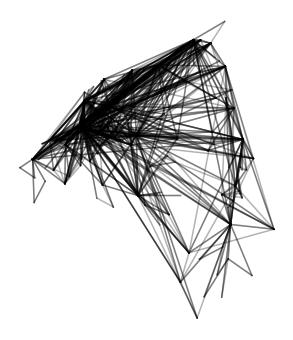

In [ ]:
# Plot airports
g = GeoPlot(
    G,
    node_lat="AEROPORTO DE ORIGEM (LAT)",
    node_lon="AEROPORTO DE ORIGEM (LONG)",
    node_size= 0.005,
)
g.draw()

## Some questions

Is there a direct flight between Rio Grande do Norte and Rio Grande do Sul? A direct flight is one with no intermediate stops.

In [ ]:
rn_airports = [node for node in G.nodes if G.nodes[node]['AEROPORTO DE ORIGEM (UF)'] == 'RN']
rs_airports = [node for node in G.nodes if G.nodes[node]['AEROPORTO DE ORIGEM (UF)'] == 'RS']

# For every combination of airports (RN to RS)
for airports in itertools.product(rn_airports, rs_airports):
    if airports[1] in G.neighbors(airports[0]):
        print(f'Has a flight from {airports[0]} (RN) to {airports[1]} (RS)')

R: No, has no direct flight from RN to RS

If I wanted to fly from Rio Grande do Norte to Rio Grande do Sul, what would be an itinerary with the fewest number of flights?

In [ ]:
rn_airports = [node for node in G.nodes if G.nodes[node]['AEROPORTO DE ORIGEM (UF)'] == 'RN']
rs_airports = [node for node in G.nodes if G.nodes[node]['AEROPORTO DE ORIGEM (UF)'] == 'RS']

# For every combination of airports (RN to RS)
for airports in itertools.product(rn_airports, rs_airports):
    print(f'From {airports[0]}(RN) to {airports[1]}(RS): {nx.shortest_path_length(G, airports[0], airports[1])} flights')

From SBSG(RN) to SBPA(RS): 2 flights
From SBSG(RN) to SBCX(RS): 2 flights
From SBSG(RN) to SBNM(RS): 3 flights
From SBSG(RN) to SBUG(RS): 3 flights
From SBSG(RN) to SBPK(RS): 3 flights
From SBSG(RN) to SBSM(RS): 3 flights
From SBSG(RN) to SBPF(RS): 2 flights
From SBSG(RN) to SSCN(RS): 3 flights
From SBMS(RN) to SBPA(RS): 2 flights
From SBMS(RN) to SBCX(RS): 3 flights
From SBMS(RN) to SBNM(RS): 3 flights
From SBMS(RN) to SBUG(RS): 3 flights
From SBMS(RN) to SBPK(RS): 3 flights
From SBMS(RN) to SBSM(RS): 3 flights
From SBMS(RN) to SBPF(RS): 3 flights
From SBMS(RN) to SSCN(RS): 3 flights


Is it possible to travel from any airport in the BR to any other airport in the BR, possibly using connecting flights? In other words, does there exist a path in the network between every possible pair of airports?

In [84]:
for component in nx.strongly_connected_components(G):
    if len(component) == 1:
        print(f'{len(component)} | {list(component)[0]} {G.nodes[list(component)[0]]}')
    else:
        print(f'{len(component)}')

1 | SNCX {'AEROPORTO DE ORIGEM (NOME)': 'COLATINA', 'AEROPORTO DE ORIGEM (UF)': 'ES', 'AEROPORTO DE ORIGEM (LAT)': -40.57939910888672, 'AEROPORTO DE ORIGEM (LONG)': -19.48699951171875}
1 | SBBU {'AEROPORTO DE ORIGEM (NOME)': 'BAURU', 'AEROPORTO DE ORIGEM (UF)': 'SP', 'AEROPORTO DE ORIGEM (LAT)': -49.0537986755, 'AEROPORTO DE ORIGEM (LONG)': -22.3449993134}
1 | SBVG {'AEROPORTO DE ORIGEM (NOME)': 'VARGINHA', 'AEROPORTO DE ORIGEM (UF)': 'MG', 'AEROPORTO DE ORIGEM (LAT)': -45.4733009338, 'AEROPORTO DE ORIGEM (LONG)': -21.5900993347}
125


In [90]:
print('SNCX | in_degree:', G.in_degree('SNCX'), 'out_degree:', G.out_degree('SNCX'))
print('SBBU | in_degree:', G.in_degree('SBBU'), 'out_degree:', G.out_degree('SBBU'))
print('SBVG | in_degree:', G.in_degree('SBVG'), 'out_degree:', G.out_degree('SBVG'))

SNCX | in_degree: 1 out_degree: 0
SBBU | in_degree: 1 out_degree: 0
SBVG | in_degree: 1 out_degree: 0


R: No, the airports SNCX(ES), SBBU(SP) and SBVG(MG) have no flights to them.